Leadville Data Analysis

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

# connect to the database
db: str = "sloan"
host: str = "mines-sloan-database.mines.edu"
port: int = 5433

user: str = "dev_read"
password: str = "kKYow56B4dwybUMnZ9CW"

# SELECT DISTINCT sensor_type, sensor_name
# FROM emporia_sensors
# WHERE sensor_type in ('VUE002', 'WAT001', 'SSO001')
# order by sensor_name;


# VUE002 is the total power of the house
# WAT001 is the sub channels for the VUE002 it's identified as SX{manufacturer_id}
# SSO001 is the plug load meter



# SELECT 
#     time_bucket('1m', e.time) as bucketed_time, (1-60s, 1m, 5m, 15, 1h, 1d, 1w, 1m, 1y)
#     AVG(e.power) as average_power
# FROM emporia_data e
# INNER JOIN emporia_sensors s ON e.device_id = s.manufacturer_id
# WHERE s.sensor_type in ('VUE002', 'WAT001', 'SSO001')
#   AND s.sensor_name in ('Gabe Main')
#   AND e.time BETWEEN '2024-01-24T18:21:18.151Z' AND '2024-01-31T18:21:18.151Z'
# GROUP BY bucketed_time
# ORDER BY bucketed_time;


# this selects the average power usage for the total house vue2 power based on the name of the device\
# change the s.sensor_name to s.manufacturer_id to get the power usage based on manufacturer id

# ----- Sensor queries -----
device_names_query = '''
SELECT DISTINCT sensor_type, sensor_name, manufacturer_id
FROM emporia_sensors
WHERE sensor_type in ('VUE002', 'WAT001', 'SSO001')
order by sensor_name;
'''

radon_sensors = '''
select sensor_name from airthings_sensors
where sensor_type = 'WAVE_PLUS'
ORDER BY length(sensor_name), sensor_name;
'''

pm25_sensors = '''
select sensor_name from airthings_sensors
where sensor_type = 'VIEW_PLUS_BUSINESS'
order by length(sensor_name), sensor_name;
'''

# ----- Data queries -----
radon_data = '''
SELECT 
    time_bucket('{TimeBucketInterval}', ad.time) AS time,
    AVG(ad.radonshorttermavg) AS avg_radonshorttermavg, 
    AVG(ad.temp) AS avg_temp, 
    AVG(ad.humidity) AS avg_humidity, 
    AVG(ad.pressure) AS avg_pressure, 
    AVG(ad.co2) AS avg_co2, 
    AVG(ad.voc) AS avg_voc, 
    AVG(ad.light) AS avg_light 
FROM 
    airthings_data ad
JOIN 
    airthings_sensors asen 
ON 
    ad.device_id = asen.device_id
WHERE 
    asen.sensor_name in ({RadonName})
AND 
    ad.time BETWEEN $__timeFrom() AND $__timeTo()
GROUP BY 
     time_bucket('{TimeBucketInterval}', ad.time)
ORDER BY 
    time;
'''

pm25_data = '''
SELECT 
    time_bucket('5m', ad.time) AS time,
    AVG(ad.pm25) AS avg_pm25, 
    AVG(ad.temp) AS avg_temp, 
    AVG(ad.humidity) AS avg_humidity, 
    AVG(ad.pressure) AS avg_pressure, 
    AVG(ad.co2) AS avg_co2, 
    AVG(ad.voc) AS avg_voc, 
    AVG(ad.light) AS avg_light,
    AVG(ad.pm1) AS avg_pm1,
    AVG(ad.sla) AS avg_sla
FROM 
    airthings_data ad
JOIN 
    airthings_sensors asen 
ON 
    ad.device_id = asen.device_id
WHERE 
    asen.sensor_name in ('PM1') -- Assuming you replace PMSensorName with the pm sensor name variable
AND 
    ad.time BETWEEN '2024-01-24T18:45:09.099Z' AND '2024-01-31T18:45:09.099Z'
GROUP BY 
    time_bucket('5m', ad.time)
ORDER BY 
    time;
'''


main_power_selection = '''
SELECT 
    time_bucket('1m', e.time) as bucketed_time, 
    AVG(e.power) as average_power
FROM emporia_data e
INNER JOIN emporia_sensors s ON e.device_id = s.manufacturer_id
WHERE s.sensor_type = 'VUE002'
  AND s.sensor_name in ('Gabe Main')
  AND e.time BETWEEN '2024-01-24T18:21:18.151Z' AND '2024-01-31T18:21:18.151Z'
GROUP BY bucketed_time
ORDER BY bucketed_time;
'''

vue2_subchannel_power_data = '''
SELECT 
    time_bucket('{averaging_interval}', time) as bucketed_time, 
    AVG(power) as average_power
FROM emporia_data as ed
WHERE ed.device_id IN (
    SELECT es.manufacturer_id
    FROM emporia_sensors AS es
    WHERE es.sensor_type = 'WAT001'
    AND es.device_gid = (
        SELECT es2.device_gid
        FROM emporia_sensors AS es2
        WHERE es2.sensor_name in ({VUE2NAME})
        LIMIT 1
    )
)
  AND channel = {CHANNEL}
  AND time BETWEEN $__timeFrom() AND $__timeTo()
GROUP BY bucketed_time
ORDER BY bucketed_time;
'''

outlet_power_data = '''
SELECT time_bucket('{averaging_interval}', e.time) AS time, -- Set the averaging interval to the desired interval 1s, 1m, 5m, 15m, 1h, 1d, 1w, 1m, 1y etc...
       AVG(e.power) AS average_power
FROM emporia_data e
INNER JOIN emporia_sensors s ON e.device_id = s.manufacturer_id
WHERE s.sensor_name IN (PlugLoadName) -- Assuming you replace PlugLoadName with the plug load sensor name variable
      AND e.time BETWEEN {timestamp_range[0]} AND {timestamp_range[1]}
GROUP BY time_bucket('{averaging_interval}', e.time) --This is needed to correctly group the time intervals, using bucketed_time doesn't work for some reason
ORDER BY time;
'''    

In [2]:
with psycopg2.connect(dbname=db, user=user, password=password, host=host, port=port) as conn:

    with conn.cursor() as cursor:
        cursor.execute("SELECT * FROM purpleair_data LIMIT 0")
        print([desc[0] for desc in cursor.description])
        # cursor.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'""")
        # print([table for table in cursor.fetchall()])

['time', 'pm25', 'pm10', 'pm1', 'temp', 'humidity', 'pressure', 'device_id']


In [3]:
# Emporia sensors
device_names_query = '''
SELECT DISTINCT sensor_type, sensor_name, manufacturer_id
FROM emporia_sensors
WHERE sensor_type in ('VUE002', 'WAT001', 'SSO001')
order by sensor_name;
'''
with psycopg2.connect(dbname=db, user=user, password=password, host=host, port=port) as conn:

    with conn.cursor() as cursor:
        cursor.execute(device_names_query)
        devices = cursor.fetchall()
    empDevices_df = pd.DataFrame(devices, columns=['sensor_type', 'sensor_name', 'manufacturer_id'])

In [4]:
# Airthings sensors
device_names_query = '''
SELECT DISTINCT sensor_type, sensor_name, device_id
FROM airthings_sensors
order by sensor_name;
'''
with psycopg2.connect(dbname=db, user=user, password=password, host=host, port=port) as conn:

    with conn.cursor() as cursor:
        cursor.execute(device_names_query)
        devices = cursor.fetchall()
    airDevices_df = pd.DataFrame(devices, columns=['sensor_type', 'sensor_name', 'device_id'])

In [5]:
# Purpleair sensors
device_names_query = '''
SELECT DISTINCT sensor_type, sensor_name, sensor_index
FROM purpleair_sensors
order by sensor_name;
'''
with psycopg2.connect(dbname=db, user=user, password=password, host=host, port=port) as conn:

    with conn.cursor() as cursor:
        cursor.execute(device_names_query)
        devices = cursor.fetchall()
    purpleDevices_df = pd.DataFrame(devices, columns=['sensor_type', 'sensor_name', 'sensor_index'])

In [7]:
airDevices_df

,sensor_type,sensor_name,device_id
0,HUB,AH1,2820019667
1,HUB,AH2,2820019712
2,HUB,AH3,2820004418
3,HUB,AH4,2820033624
4,HUB,AH5,2820033606
5,VIEW_PLUS_BUSINESS,PM1,2969030550
6,VIEW_PLUS_BUSINESS,PM10,2969030517
7,VIEW_PLUS_BUSINESS,PM11,2969030543
8,VIEW_PLUS_BUSINESS,PM12,2969030213
9,VIEW_PLUS_BUSINESS,PM13,2969029720


In [6]:
purpleDevices_df

,sensor_type,sensor_name,sensor_index
0,PA-II-FLEX,Sloan_flex-d54e,183825
1,PA-II-FLEX,Sloan_flex-f877,183561
2,PA-II-FLEX,Sloan_zen-1,194439
3,PA-II-FLEX,Sloan_zen-2,194415
4,PA-II-FLEX,Sloan_zen-3,194427


In [15]:
timestamp_range = ('2024-05-01T00:00:00.001Z', '2024-07-01T00:00:00.001Z')

In [16]:
with psycopg2.connect(dbname=db, user=user, password=password, host=host, port=port) as conn:
    main_power_selection = f'''
    SELECT 
        time_bucket('1m', e.time) as bucketed_time, 
        AVG(e.power) as average_power
    FROM emporia_data e
    INNER JOIN emporia_sensors s ON e.device_id = s.manufacturer_id
    WHERE s.sensor_type = 'VUE002'
    AND s.sensor_name in ('V3-CE68')
    AND e.time BETWEEN '{timestamp_range[0]}' AND '{timestamp_range[1]}'
    GROUP BY bucketed_time
    ORDER BY bucketed_time;
    '''

    with conn.cursor() as cursor:
        cursor.execute(main_power_selection)
        main_power = cursor.fetchall()
    totalPower_df = pd.DataFrame(main_power, columns=['bucketed_time', 'average_power'])

In [17]:
with psycopg2.connect(dbname=db, user=user, password=password, host=host, port=port) as conn:
    vue2_subchannel_power_data = f'''
    SELECT 
        time_bucket('1m', ed.time) as bucketed_time, 
        AVG(ed.power) as average_power,
        ed.channel
    FROM emporia_data as ed
    WHERE ed.device_id IN (
        SELECT es.manufacturer_id
        FROM emporia_sensors AS es
        WHERE es.sensor_type = 'WAT001'
        AND es.device_gid = (
            SELECT es2.device_gid
            FROM emporia_sensors AS es2
            WHERE es2.sensor_name in ('V3-CE68')
            LIMIT 1
        )
    )
    AND ed.time BETWEEN '{timestamp_range[0]}' AND '{timestamp_range[1]}'
    GROUP BY bucketed_time, channel
    ORDER BY bucketed_time;
    '''

    with conn.cursor() as cursor:
        cursor.execute(vue2_subchannel_power_data)
        channel_power = cursor.fetchall()
    channelPower_df = pd.DataFrame(channel_power, columns=['bucketed_time', 'average_power', 'channel'])
channelPowers = []
for i in range(0,16):
    channelPowers.append(channelPower_df.loc[channelPower_df['channel'] == i])

In [18]:
with psycopg2.connect(dbname=db, user=user, password=password, host=host, port=port) as conn:
    TimeBucketInterval = '1m'
    radon_data = f'''
    SELECT 
        time_bucket('{TimeBucketInterval}', ad.time) AS time,
        AVG(ad.temp) AS avg_temp
    FROM 
        airthings_data ad
    JOIN 
        airthings_sensors asen 
    ON 
        ad.device_id = asen.device_id
    WHERE 
        asen.sensor_name in ('R3')
    AND 
        ad.time BETWEEN '{timestamp_range[0]}' AND '{timestamp_range[1]}'
    GROUP BY 
        time_bucket('{TimeBucketInterval}', ad.time)
    ORDER BY 
        time;
    '''

    pm25_data = f'''
    SELECT 
        time_bucket('1m', ad.time) AS time,
        AVG(ad.temp) AS avg_temp
    FROM 
        airthings_data ad
    JOIN 
        airthings_sensors asen 
    ON 
        ad.device_id = asen.device_id
    WHERE 
        asen.sensor_name in ('PM3')
    AND 
        ad.time BETWEEN '{timestamp_range[0]}' AND '{timestamp_range[1]}'
    GROUP BY 
        time_bucket('1m', ad.time)
    ORDER BY 
        time;
    '''

    purple_data = f'''
    SELECT 
        time_bucket('{TimeBucketInterval}', ad.time) AS time,
        AVG(ad.temp) AS avg_temp,
        asen.sensor_name
    FROM 
        purpleair_data ad
    JOIN 
        purpleair_sensors asen 
    ON 
        ad.device_id = asen.sensor_index
    WHERE 
        asen.sensor_name in ('Sloan_flex-f877', 'Sloan_flex-d54e')
    AND 
        ad.time BETWEEN '{timestamp_range[0]}' AND '{timestamp_range[1]}'
    GROUP BY 
        time_bucket('{TimeBucketInterval}', ad.time),
        asen.sensor_name
    ORDER BY 
        time;
    '''

    with conn.cursor() as cursor:
        cursor.execute(radon_data)
        radon_temp = cursor.fetchall()

        cursor.execute(pm25_data)
        pm25_temp = cursor.fetchall()

        cursor.execute(purple_data)
        purple_temp = cursor.fetchall()
    radonTemp_df = pd.DataFrame(radon_temp, columns=['bucketed_time', 'avg_temp'])
    pm25Temp_df = pd.DataFrame(pm25_temp, columns=['bucketed_time', 'avg_temp'])
    purpleTemp_df = pd.DataFrame(purple_temp, columns=['bucketed_time', 'avg_temp', 'sensor_name'])
purpleAirs = []
for name in ('Sloan_flex-f877', 'Sloan_flex-d54e'):
    purpleAirs.append(purpleTemp_df.loc[purpleTemp_df['sensor_name'] == name])

In [19]:
# radonTemp_df.to_csv('indoorTemp_radon.csv', index=False)
# pm25Temp_df.to_csv('indoorTemp_pm25.csv', index=False)
# purpleAirs[0].to_csv('outdoorTemp_f877.csv', index=False)
# purpleAirs[1].to_csv('outdoorTemp_d54e.csv', index=False)

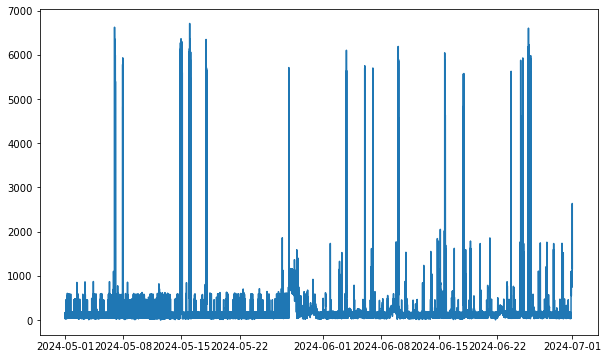

In [20]:
figure = plt.figure(figsize=(10, 6))
plt.plot(totalPower_df['bucketed_time'], totalPower_df['average_power'])

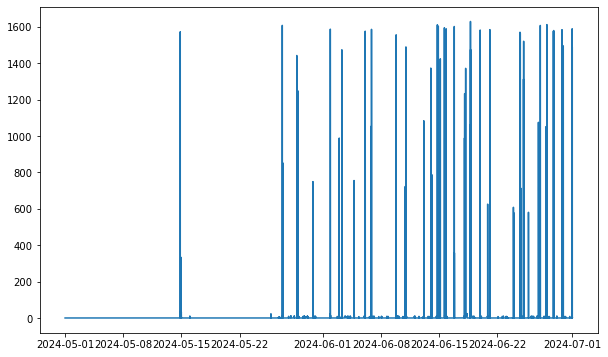

In [26]:
fig = plt.figure(figsize=(10,6))
# for chan in channelPowers:
#     plt.plot(chan['bucketed_time'], chan['average_power'])
chan = channelPowers[1]
plt.plot(chan['bucketed_time'], chan['average_power'])
# plt.xlim(19850.5, 19851.5)

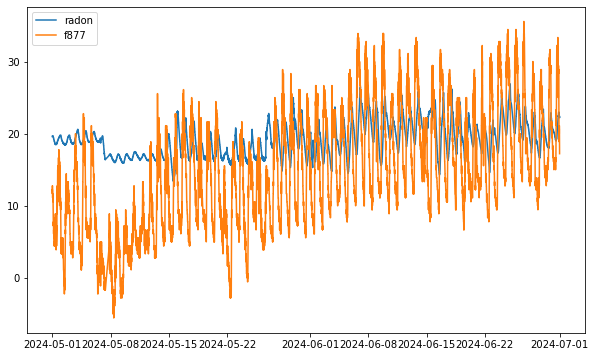

In [27]:
fig = plt.figure(figsize=(10,6))
plt.plot(radonTemp_df['bucketed_time'], radonTemp_df['avg_temp'], label='radon')
# plt.plot(pm25Temp_df['bucketed_time'], pm25Temp_df['avg_temp'], label='pm25')
plt.plot(purpleAirs[0]['bucketed_time'], purpleAirs[0]['avg_temp'], label='f877')
# plt.plot(purpleAirs[1]['bucketed_time'], purpleAirs[1]['avg_temp'], label='d54e')
# plt.xlim([pm25Temp_df['bucketed_time'][0], pm25Temp_df['bucketed_time'][287]])
plt.legend()